In [206]:
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from PIL import Image
import cv2
from tqdm import tqdm as tqdm
from sklearn.cluster import KMeans
import os

In [207]:
df.head()

,cartesianX,cartesianY,cartesianZ,intensity,colorRed,colorGreen,colorBlue,label_c
112798,-1.2325,-18.309500,-0.3285,0.199112,91,94,83,0
112800,-1.2265,-18.308500,-0.3275,0.367249,91,93,77,1
112801,-1.2315,-18.309500,-0.3235,0.194687,88,93,62,0
112802,-1.2265,-18.307501,-0.3205,0.389374,92,94,80,1
112867,-1.2105,-18.308500,-0.3295,0.327423,97,92,82,0


In [208]:
df = pd.read_pickle("data/df_reduced.pkl")
print(df.shape)
df  = df[df.intensity > 0.1]
print(df.shape)

(37792346, 7)
(26038963, 7)


In [209]:
clustering1_inp = df[["intensity"]].values

In [210]:
kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=20, precompute_distances=True).fit(clustering1_inp)

/home/toto/Hackathons/TrumpFFF/venv/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:934: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  "effect", FutureWarning)
/home/toto/Hackathons/TrumpFFF/venv/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [211]:
df["label_c"] = kmeans.labels_

In [212]:
def get_distributions(df:pd.DataFrame, col:str):
    dc = df[col]
    dc.plot.hist(bins=90)
    plt.show()
    plt.close()
    print(dc.describe())
    return dc

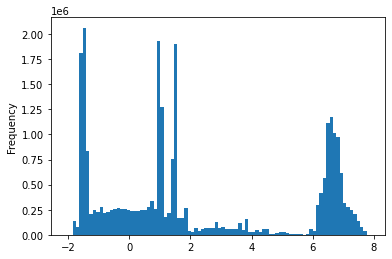

count    2.603896e+07
mean     2.185853e+00
std      3.178852e+00
min     -2.081500e+00
25%     -5.595000e-01
50%      1.056500e+00
75%      6.398500e+00
max      7.883500e+00
Name: cartesianZ, dtype: float64


In [213]:
dc  = get_distributions(df, "cartesianZ")

In [214]:
dc_hist = np.histogram(dc.values, bins=80)

In [215]:
hist_weights = dc_hist[0] / dc_hist[0].sum()

In [216]:
hist_centers = dc_hist[1]

In [217]:
sampled_data = np.random.choice(hist_centers[1:], size=10000, p = hist_weights)

In [218]:
gmm = GaussianMixture(5)
gmm = gmm.fit(sampled_data.reshape(-1,1))

In [219]:
floor_id = np.argmin(gmm.means_)
ceil_id = np.argmax(gmm.means_)

floor_cutoff = (gmm.means_[floor_id] + np.sqrt(gmm.covariances_[floor_id])*2).reshape(-1)[0]
ceil_cutoff = (gmm.means_[ceil_id] - np.sqrt(gmm.covariances_[ceil_id])*2).reshape(-1)[0]

In [220]:
floor_cutoff

-1.3395916572439275

In [221]:
ceil_cutoff

6.117725003618646

In [222]:
df = df[df.cartesianZ > floor_cutoff]
df = df[df.cartesianZ < ceil_cutoff-2]


In [223]:
df_plot = df[["cartesianX", "cartesianY", "intensity"]]

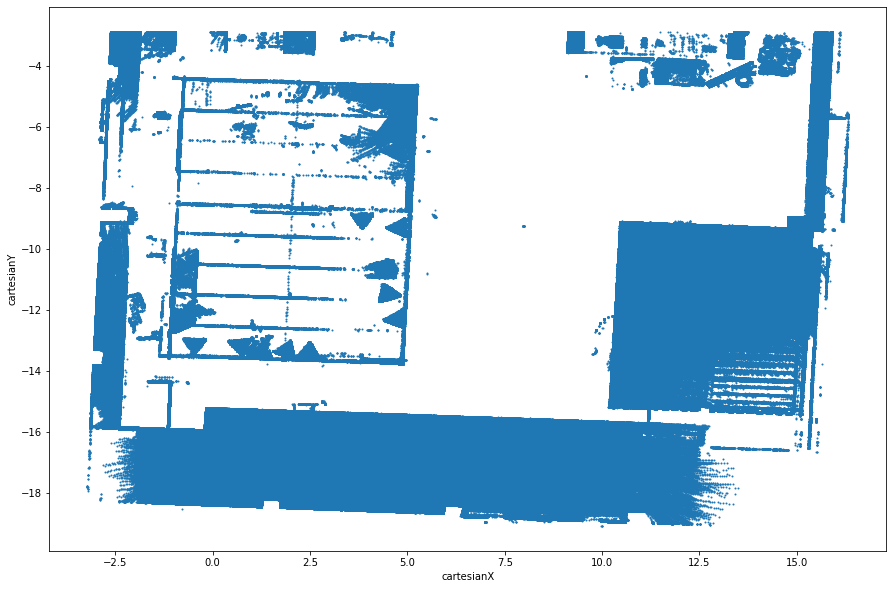

In [224]:
df_plot.plot.scatter("cartesianX", "cartesianY", s = 1, figsize=(15,10))
plt.show()

In [225]:
# Quick experiment to pixel

In [226]:
coords = df[["cartesianX", "cartesianY", "cartesianZ"]].copy()

minx = coords.cartesianX.min()
miny = coords.cartesianY.min()

coords.cartesianX -= minx
coords.cartesianY -= miny

coords.cartesianX *= (100 / 4)
coords.cartesianX = coords.cartesianX.round().astype(np.int32)

coords.cartesianY *= (100 / 4)
coords.cartesianY = coords.cartesianY.round().astype(np.int32)

maxx = coords.cartesianX.max()
maxy = coords.cartesianY.max()

In [227]:
matrix_bw_original = np.zeros([maxx+1, maxy+1], np.uint8)
matrix_bw_original[coords.cartesianX.values, coords.cartesianY.values] = 255

# Smooth:
img = matrix_bw_original

img = cv2.medianBlur(img, 3)

kernel = np.ones((3,3),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # erosion followed by dilation
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)  # dilation follows by erosion





# # Edge Detection
# # kernel = np.ones((9,9),np.uint8)
# # img = cv2.erode(img,kernel,iterations = 1)
# # img = cv2.Canny(img, 450,900, 3)
# # TO img

img = Image.fromarray(img, "L")
(width, height) = (img.width // 4, img.height // 4)
img = img.resize((width, height))
img.save('data/image.png')
img.show()

In [228]:
def process_img_(img, in_loop=True, only_postprocessing = False):
    
    if not in_loop:
        kernel = kernel = np.zeros((5,5),np.uint8)
        kernel[:,2] = 1
        img = cv2.dilate(img,kernel,iterations = 1)
        return img
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)) 
    img = cv2.dilate(img,kernel,iterations = 1)
    
    # Diagonal
    kernel = np.zeros((3,3),np.uint8)
    for i in range(kernel.shape[0]):
        kernel[i, i] = 1
        kernel[-i-1, i] = 1
    img = cv2.dilate(img,kernel,iterations = 1)
    
    if only_postprocessing:
        return img
    
    if in_loop:
        kernel = np.ones((5,5),np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)  # dilation follows by erosion
        #img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # erosion followed by dilation
    return img


In [229]:
def _process_horizontal_slice(coords, maxx, maxy, z_step):
    matrix_bw_original = np.zeros([int(maxx+1), int(maxy+1)], np.uint8)
    matrix_bw_original[coords.cartesianX.values, coords.cartesianY.values] = 255
    # Smooth:
    img = matrix_bw_original
    
    # Horizontal and Vertical
    img = process_img_(img)
    img_ = Image.fromarray(img, "L")
    (width, height) = (img_.width // 4, img_.height // 4)
    img_ = img_.resize((width, height))
    img_.save(f'data/cuts/image_{z_step}.png')
    return img

In [230]:
def process_3d(all_data: pd.DataFrame, step_z_in_m=0.05):
    # get startx, start y coords

    coords = all_data.copy()
    
    # Pixel per CM # TODO check this please Todor is being stupid
    coords.cartesianX *= 50
    coords.cartesianX = coords.cartesianX.round().astype(np.int32)
    coords.cartesianY *= 50
    coords.cartesianY = coords.cartesianY.round().astype(np.int32)

    
    minx = coords.cartesianX.min()
    miny = coords.cartesianY.min()
    
    coords.cartesianX -= minx
    coords.cartesianY -= miny
    
    maxx = coords.cartesianX.max()
    maxy = coords.cartesianY.max()
    
    min_max_dict = {}
    min_max_dict["minx"] = minx
    min_max_dict["miny"] = miny
    min_max_dict["maxx"] = maxx
    min_max_dict["maxy"] = maxy
    
        
    cuts = []
    cuts_z_coord = []
    
    range_z = coords.cartesianZ.max() - coords.cartesianZ.min() 
    steps_z = int(np.ceil(range_z / step_z_in_m))
    
    current_z = coords.cartesianZ.min()
    
    for step in tqdm(range(steps_z)):
        upper = current_z + step_z_in_m
        
        # Get data
        cuts.append((coords[(current_z <= coords.cartesianZ) & (coords.cartesianZ < upper)])[["cartesianX", "cartesianY"]].copy())
        cuts_z_coord.append((current_z + upper)/2)
        
        
        current_z  = upper
    
    
    img_list  = Parallel(n_jobs=2)(delayed(_process_horizontal_slice)(cuts[int(i)], maxx, maxy, int(i)) for i in tqdm(range(steps_z)))
    
    return min_max_dict, cuts, cuts_z_coord, img_list
    


In [233]:
df.label_c.unique()

array([0, 1], dtype=int32)

In [232]:
for class_ in df["label_c"].unique():
    df_ = df[df.label_c == class_].copy()
    min_max_dict, cuts, cuts_z_coord, img_list = process_3d(df_[["cartesianX", "cartesianY", "cartesianZ"]].copy())
    d3_img = np.stack(img_list, axis=0)
    
    for z in tqdm(range(d3_img.shape[0])): # move along z
        img = d3_img[z,:,:]
        #img = process_img_(img, only_postprocessing=True)
        d3_img[z,:,:]  = img
    
    for i in tqdm(range(d3_img.shape[1])): # move along x
        img = d3_img[:,i,:]
        img = process_img_(img, in_loop=False)
        d3_img[:,i,:]  = img

    for j in tqdm(range(d3_img.shape[2])): # move along y
        img = d3_img[:,:,j]
        img = process_img_(img, in_loop=False)
        d3_img[:,:,j]  = img
       
    
    # Plot
    for z in tqdm(range(d3_img.shape[0])): # move along z
        img = d3_img[z,:,:]
        img_ = Image.fromarray(img, "L")
        (width, height) = (img_.width // 4, img_.height // 4)
        img_ = img_.resize((width, height))
        os.makedirs(f'data/col_clustered/class_{class_}/', exist_ok=True)
        img_.save(f'data/col_clustered/class_{class_}/image_{z}.png')


100%|██████████| 108/108 [00:00<00:00, 167.13it/s]


In [238]:
# No classes here

min_max_dict, cuts, cuts_z_coord, img_list = process_3d(df[["cartesianX", "cartesianY", "cartesianZ"]].copy(), 0.15)
d3_img = np.stack(img_list, axis=0)

# for z in tqdm(range(d3_img.shape[0])): # move along z
#     img = d3_img[z,:,:]
#     img = process_img_(img, in_loop=False)
#     d3_img[z,:,:]  = img


for i in tqdm(range(d3_img.shape[1])): # move along x
    img = d3_img[:,i,:]
    img = process_img_(img, in_loop=False)
    d3_img[:,i,:]  = img

for j in tqdm(range(d3_img.shape[2])): # move along y
    img = d3_img[:,:,j]
    img = process_img_(img, in_loop=False)
    d3_img[:,:,j]  = img

    
for j in tqdm(range(d3_img.shape[2])): # move along y
    img = d3_img[:,:,j]
    img = process_img_(img, in_loop=False)
    d3_img[:,:,j]  = img


for i in tqdm(range(d3_img.shape[1])): # move along x
    img = d3_img[:,i,:]
    img = process_img_(img, in_loop=False)
    d3_img[:,i,:]  = img
       
    
for z in tqdm(range(d3_img.shape[0])): # move along z
    img = d3_img[z,:,:]
    kernel = np.zeros((3,3),np.uint8)
    img = cv2.erode(img,kernel,iterations = 1) # Slim down
    
    img_ = Image.fromarray(img, "L")
    
    edged = cv2.Canny(img, 127,255,cv2.THRESH_BINARY)
    contours,h = cv2.findContours(edged, 1, 2)
    ####
#     (width, height) = (img_.width // 4, img_.height // 4)
#     img_ = img_.resize((width, height))
    target_dir = f'data/just_filtered/'
    os.makedirs(target_dir, exist_ok=True)
    img_.save(f'{target_dir}/image_{z}.png')
    
    # Do color for labeling
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        if len(approx)==5:
            #print("pentagon")
            cv2.drawContours(img,[cnt],0,255,-1)
        elif len(approx)==3:
            #print("triangle")
            cv2.drawContours(img,[cnt],0,(0,255,0),-1)
        elif len(approx)==4:
            #print("square")
            cv2.drawContours(img,[cnt],0,(0,0,255),-1)
        elif len(approx) == 9:
            #print("half-circle")
            cv2.drawContours(img,[cnt],0,(255,255,0),-1)
        elif len(approx) > 15:
            #print("circle")
            cv2.drawContours(img,[cnt],0,(0,255,255),-1)
    img = Image.fromarray(img, "RGB")
    img.save(f'{target_dir}/image_{z}_labeled.png')


100%|██████████| 37/37 [00:02<00:00, 15.54it/s]


In [182]:
final_projection = np.max(d3_img, axis=0)
img_ = Image.fromarray(final_projection, "L")
(width, height) = (img_.width // 4, img_.height // 4)
img_ = img_.resize((width, height))
target_dir = f'data/just_filtered/'
os.makedirs(target_dir, exist_ok=True)
img_.save(f'{target_dir}/image_{z}.png')
img_.save(f'data/for_contour.png')
